In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
import scipy.sparse.linalg as la

In [2]:
#3.2 Implementation and Numerical Experiments
LeftX = 0.0
RightX = 10.0
LeftY = 0.0
RightY = 5.0
Nx = 200 # number of intervals in x-direction
Ny = 100 # number of intervals in y-direction
dx = (RightX-LeftX)/Nx # grid step in x-direction
dy =(RightY-LeftY)/Ny # grid step in y-direction
Lx=10.0 #same as rightx but im lazy to change Lx in an equation I already typed
Ly=5.0 #same as righty

In [3]:
#1.
def sourcefunc(x,y,t):
    f=-np.sin(4*np.pi*t)*(np.exp(-40.0*(((x-0.25*Lx)*(x-0.25*Lx))+((y-0.25*Ly)*(y-0.25*Ly))))+np.exp(-40.0*(((x-0.25*Lx)*(x-0.25*Lx))+((y-0.75*Ly)*(y-0.75*Ly))))+np.exp(-40.0*(((x-0.75*Lx)*(x-0.75*Lx))+((y-0.75*Ly)*(y-0.75*Ly))))+np.exp(-40.0*(((x-0.75*Lx)*(x-0.75*Lx))+((y-0.25*Ly)*(y-0.25*Ly)))))
    return f
def coeffK(x,y):
    K=(np.logical_and(x<Lx/2, y<Ly/2)*0.1)+(np.logical_and(x<Lx/2,y>=Ly/2)*0.4)+(np.logical_and(x>=Lx/2,y>=Ly/2)*0.7)+(np.logical_and(x>=Lx/2,y<Ly/2)*1.0)
    return K
def create2DLFVM(Nx,Ny,LeftX,RightX,LeftY,RightY,coeffFun):
    dx = (RightX-LeftX)/Nx # grid step in x-direction
    dy =(RightY-LeftY)/Ny # grid step in y-direction
    x=np.linspace(LeftX,RightX,Nx)
    y=np.linspace(LeftY,RightY,Ny)
    diag0=np.zeros((Nx-1)*(Ny-1))
    diagimin1=np.zeros((Nx-1)*(Ny-1)-1)
    diagiplus1=np.zeros((Nx-1)*(Ny-1)-1)
    diagjmin1=np.zeros((Nx-1)*(Ny-2))
    diagjplus1=np.zeros((Nx-1)*(Ny-2))
    n0=0
    nip1=0
    nim1=0
    njp1=0
    njm1=0
    for j in range(Ny-1):
        for i in range(Nx-1):
            diag0[n0]=(((coeffFun(x[i]-0.5*dx,y[j])+coeffFun(x[i]+0.5*dx,y[j]))/(dx**2))+((coeffFun(x[i],y[j]-0.5*dy)+coeffFun(x[i],y[j]+0.5*dy))/(dy)**2))
            n0=n0+1
            if (i<(Nx-2)):
                diagiplus1[nip1]=((-coeffFun(x[i]+0.5*dx,y[j]))/(dx**2))
                nip1=nip1+1
            elif (i==Nx-2):
                nip1=nip1+1
            if (i>(0)):
                diagimin1[nim1]=((-coeffFun(x[i]-0.5*dx,y[j]))/(dx**2))
                nim1=nim1+1
            elif (i==0) and (j>0):
                nim1=nim1+1
            if (j<(Ny-2)):
                diagjplus1[njp1]=((-coeffFun(x[i],y[j]+0.5*dy)/(dy**2)))
                njp1=njp1+1
            if (j>(0)):
                diagjmin1[njm1]=((-coeffFun(x[i],y[j]-0.5*dy))/(dy**2))
                njm1=njm1+1    
    A=sp.diags([diag0, diagimin1, diagiplus1, diagjmin1, diagjplus1] , [0, -1, 1, -Nx+1, Nx-1], shape=((Nx-1)*(Ny-1),(Nx-1)*(Ny-1)) , format='csc')
    return A
# def stepWave(u0Start,u1Start,tStart,dt,A,f,x,y,Nt):
#     for i in range(2,Nt):
#         uEnd=2*u1Start-u0Start+(h**2)*(-A*u1Start+f(x,y,tStart))
#         tStart=tStart+2*dt
#         u0Start=u1Start
#         u1Start=uEnd
#     return uEnd
def stepWave(u0Start,u1Start,tStart,dt):
    uEnd=2*u1Start-u0Start+(h**2)*(-A*u1Start+f(x,y,tStart+(2*dt)))
    tStart=tStart+2*dt
    u0Start=u1Start
    u1Start=uEnd
    return uEnd

In [4]:
#2.
tStart=0
tEnd=4
A=create2DLFVM(Nx,Ny,LeftX,RightX,LeftY,RightY,coeffK)
print(A.toarray())
print(np.shape(A))
val,vec=la.eigs(A)
maxev=np.max(val)
h=dx*dx
Nt=(tEnd-tStart)/h
# t=np.linspace(tStart,tEnd,Nt)
x=np.linspace(LeftX,RightX,Nx)
y=np.linspace(LeftY,RightY,Ny)
# f=sourcefunc(x,y,tStart+h) 
print ("The stable time step is ", h)
print ("The stable number of time steps is ", Nt)

[[ 160.  -40.    0. ...    0.    0.    0.]
 [ -40.  160.  -40. ...    0.    0.    0.]
 [   0.  -40.  160. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 1120. -280.    0.]
 [   0.    0.    0. ... -280. 1120. -280.]
 [   0.    0.    0. ...    0. -280. 1120.]]
(19701, 19701)
The stable time step is  0.0025000000000000005
The stable number of time steps is  1599.9999999999998


TypeError: 'float' object cannot be interpreted as an integer

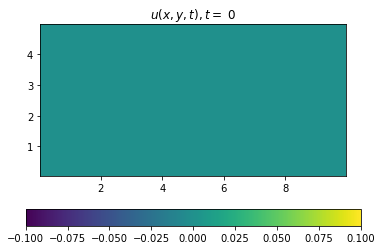

In [28]:
#3.
plt.ion()
fig = plt.figure(1)
plt.clf()
t = 0
u0=np.zeros((Nx-1)*(Ny-1))
u1 = np.copy(u0)
u2 = np.copy(u1)
u3 = np.copy(u1)
# figure initialization
u3arr = np.reshape(u3,[Ny-1,Nx-1])
img=plt.imshow(u3arr, extent=[dx/2,Lx-dx/2,Ly-dy/2,dy/2],interpolation='none')
plt.gca().invert_yaxis()
plt.colorbar(img, orientation='horizontal')
tlt = plt.title(r"$u(x,y,t), t =$ "+str(np.round(t,3)))
def animate(frame):
#     ’’’This function updates
#     the solution array’’’
    global t, dt, Nx, Ny, u0, u1, u2, u3
    t = frame*dt
    if frame == 0:
        u1 = np.copy(u0)
    u3 = np.copy(stepWave(u1,u2,t,dt))
    u1 = np.copy(u2)
    u2 = np.copy(u3)
    img.set_array(np.reshape(u3,[Ny-1,Nx-1]))
    tlt.set_text(r"$u(x,y,t), t =$ "+str(np.round(t+2*dt,3)))
    img.set_clim(u3.min(),u3.max())
    return img
anim = animation.FuncAnimation(fig,animate, Nt-1,interval=50,repeat=False)
plt.pause(Nt*5e-2)

In [30]:
#4.
u0Start=np.zeros((Nx-1)*(Ny-1))
u0Start=np.reshape(uStart,((Nx-1)*(Ny-1),1))
print(np.shape(uStart))
u=stepWave(u0Start,u1Start,tStart,h)
# print(u1FE)
# print(np.shape(u1FE))
uArr = np.reshape(u,((Nx-1),(Ny-1)))
plt.ion()
plt.figure(2)
plt.clf()
plt.imshow(uArr.transpose(),extent=[LeftX,RightX, LeftY,RightY]) # use the f array here #,extent=[LeftX,RightX, LeftY,RightY]
plt.colorbar()
plt.xlabel('X values of the grid')
plt.ylabel('Y values of the grid')
plt.title('Heat map of the numerical approximation of u(x,y,T) for T=4')

(19701, 1)


NameError: name 'u1Start' is not defined